## Assess the error associated with using annual-mean tendencies to calculate WMT
This is motivated by the advent of OM4_highres and the call for diagnostics. Is it sufficient to have the tendencies output as an annual mean, or do they need to be monthly or higher?

In [16]:
# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
from xgcm import Grid
# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")
# Set figure font size
plt.rcParams.update({'font.size':14})

In [17]:
# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
gridname = 'native'
prefix = '19000101.ocean_'
# Diagnostics were saved into different files
suffixs = ['1900','heat','salt']
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()

# Specify the diffusive tendency terms
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':'opottemppmdiff',
         'frazil ice':'frazil_heat_tendency',
         'internal heat':'internal_heat_heat_tendency'}
colors = {}
colors['heat'] = {'boundary forcing':'tab:blue',
         'vertical diffusion':'tab:orange',
         'neutral diffusion':'tab:green',
         'frazil ice':'tab:red',
         'internal heat':'tab:purple'}
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.2
lmin = -2
lmax = 10
bins = np.arange(lmin,lmax,delta_l)
# Specify constants for the reference density and the specific heat capacity
rho0 = 1035.
Cp = 3992.

In [18]:
G_monthly = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    nanmask = np.isnan(ds[term])
    G_monthly[process] = histogram(ds['temp'].where(~nanmask).squeeze(),
                        bins=[bins],
                        dim=['xh','yh','zl'],
                        weights=(
                            rho0*(ds[term]/(Cp*rho0)
                                 )*grid['areacello']
                        ).where(~nanmask).squeeze()
                          )/np.diff(bins)

In [19]:
G_yearly = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    nanmask = np.isnan(ds[term].mean('time'))
    G_yearly[process] = histogram(ds['temp'].mean('time').where(~nanmask).squeeze(),
                        bins=[bins],
                        dim=['xh','yh','zl'],
                        weights=(
                            rho0*(ds[term].mean('time')/(Cp*rho0)
                                 )*grid['areacello']
                        ).where(~nanmask).squeeze()
                          )/np.diff(bins)

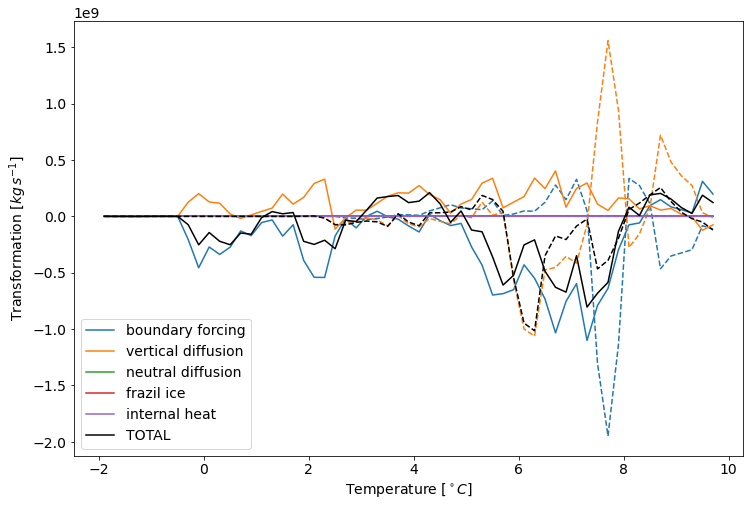

In [20]:
# Plot the time-mean transformation
fig, ax = plt.subplots(figsize=(12,8))
total_monthly = xr.zeros_like(G_monthly[processes[0]].mean('time'))
total_yearly = xr.zeros_like(G_yearly[processes[0]])
for process in processes:
    ax.plot(G_monthly['temp_bin'],G_monthly[process].mean('time'),label=process,color=colors['heat'][process])
    ax.plot(G_yearly['temp_bin'],G_yearly[process],linestyle='--',color=colors['heat'][process])
    total_monthly += G_monthly[process].mean('time')
    total_yearly += G_yearly[process]
ax.plot(G['temp_bin'],total_monthly,color='k',label='TOTAL')
ax.plot(G['temp_bin'],total_yearly,linestyle='--',color='k')
ax.legend(loc='lower left')
ax.set_xlabel('Temperature [$^\circ C$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');